In [234]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Data Analysis

After loading the company .csv file, I will examine each column to understand its structure and identify potential improvements.

### The companies dataset

In [350]:
companies = pd.read_csv("data\ml_insurance_challenge.csv")
companies.head(3)

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming


In [334]:
print(companies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9494 entries, 0 to 9493
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    9482 non-null   object
 1   business_tags  9494 non-null   object
 2   sector         9467 non-null   object
 3   category       9467 non-null   object
 4   niche          9494 non-null   object
dtypes: object(5)
memory usage: 371.0+ KB
None


In [351]:
print(companies.isnull().sum())

description      12
business_tags     0
sector           27
category         27
niche             0
dtype: int64


We can observe that all columns are of type string, and there are NaN values present in the "description", "sector", and "category" columns.

### Data Cleaning

In this step, I will clean the NaN values and format each column individually. For the "business_tags" column, I will remove the list format and ensure that the words appear sequentially.

In [352]:
# 1. Cleaning description:

companies["description"].isna().value_counts()

description
False    9482
True       12
Name: count, dtype: int64

In [353]:
# Because there are only 12 rows with no description out of 9482 we will drop those.
companies = companies.dropna(subset=["description"])
companies["description"].isna().value_counts()

description
False    9482
Name: count, dtype: int64

In [354]:
# 2. Cleaning business_tags:

companies["business_tags"].isna().value_counts() #All companies has at least 1 tag

business_tags
False    9482
Name: count, dtype: int64

We'll put all tags in individual columns, to have a better perspective on them

In [355]:
companies["max_tags"] = companies["business_tags"].apply(lambda x: x.count(', ') + 1 if x != [] else 0)
companies.head(5)

,description,business_tags,sector,category,niche,max_tags
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction,6
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing",14
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming,15
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an...",2
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water",7


In [356]:
companies["business_tags"] = companies["business_tags"].str.replace(r"[\[\]']", "", regex = True)
tags_df = companies["business_tags"].str.split(", ", expand=True)

tags_df.columns = ["business_tag_" + str(i) for i in range(tags_df.shape[1])]
companies = companies.drop(columns="max_tags").join(tags_df)
companies.head(5)

,description,business_tags,sector,category,niche,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,Welchcivils is a civil engineering and constru...,"Construction Services, Multi-utilities, Utilit...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction,Construction Services,Multi-utilities,Utility Network Connections Design and Constru...,Water Connection Installation,Multi-utility Connections,...,None,None,None,None,None,None,None,None,None,None
1,"Kyoto Vegetable Specialists Uekamo, also known...","Wholesale, Dual-task Movement Products, Cast I...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing",Wholesale,Dual-task Movement Products,Cast Iron Products Manufacturer,Manufacturing Technology,Food and Beverage,...,None,None,None,None,None,None,None,None,None,None
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"Living Forms, Farm Cafe, Fresh Coffee, Communi...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming,Living Forms,Farm Cafe,Fresh Coffee,Community Engagement,Freshly Baked Bread,...,None,None,None,None,None,None,None,None,None,None
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"Automotive Body Repair Services, Interior Repa...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an...",Automotive Body Repair Services,Interior Repair Services,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"Cultural Activities, Accommodation Services, K...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water",Cultural Activities,Accommodation Services,Kayak Rentals,Small Gastronomy Products,Tourism Services,...,None,None,None,None,None,None,None,None,None,None


In [346]:
# 3. Cleaning "sector", "category" and "niche": 

for column in ['sector', 'category', 'niche']:
    unique_val = len(companies[column].unique())
    null_val = companies[column].isna().sum()
    print(column)
    print("Unique values: ", unique_val)
    print("Number of null values: ", null_val)

sector
Unique values:  8
Number of null values:  27
category
Unique values:  451
Number of null values:  27
niche
Unique values:  957
Number of null values:  0


In [347]:
# For all companies that sector is NaN also category is NaN
companies[companies["sector"].isna() & companies["category"].isna()].shape[0]

27

In [357]:
# Since there are only a few companies without a sector, we can drop them.
companies = companies.dropna(subset=["sector"])

In [358]:
companies.head(3)

,description,business_tags,sector,category,niche,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,Welchcivils is a civil engineering and constru...,"Construction Services, Multi-utilities, Utilit...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction,Construction Services,Multi-utilities,Utility Network Connections Design and Constru...,Water Connection Installation,Multi-utility Connections,...,None,None,None,None,None,None,None,None,None,None
1,"Kyoto Vegetable Specialists Uekamo, also known...","Wholesale, Dual-task Movement Products, Cast I...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing",Wholesale,Dual-task Movement Products,Cast Iron Products Manufacturer,Manufacturing Technology,Food and Beverage,...,None,None,None,None,None,None,None,None,None,None
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"Living Forms, Farm Cafe, Fresh Coffee, Communi...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming,Living Forms,Farm Cafe,Fresh Coffee,Community Engagement,Freshly Baked Bread,...,None,None,None,None,None,None,None,None,None,None


C:\Users\andreea\AppData\Local\Temp\ipykernel_23740\3700835345.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tags_per_sector = tag_counts.groupby("sector").apply(lambda x: x.nlargest(10, "count")).reset_index(drop=True)


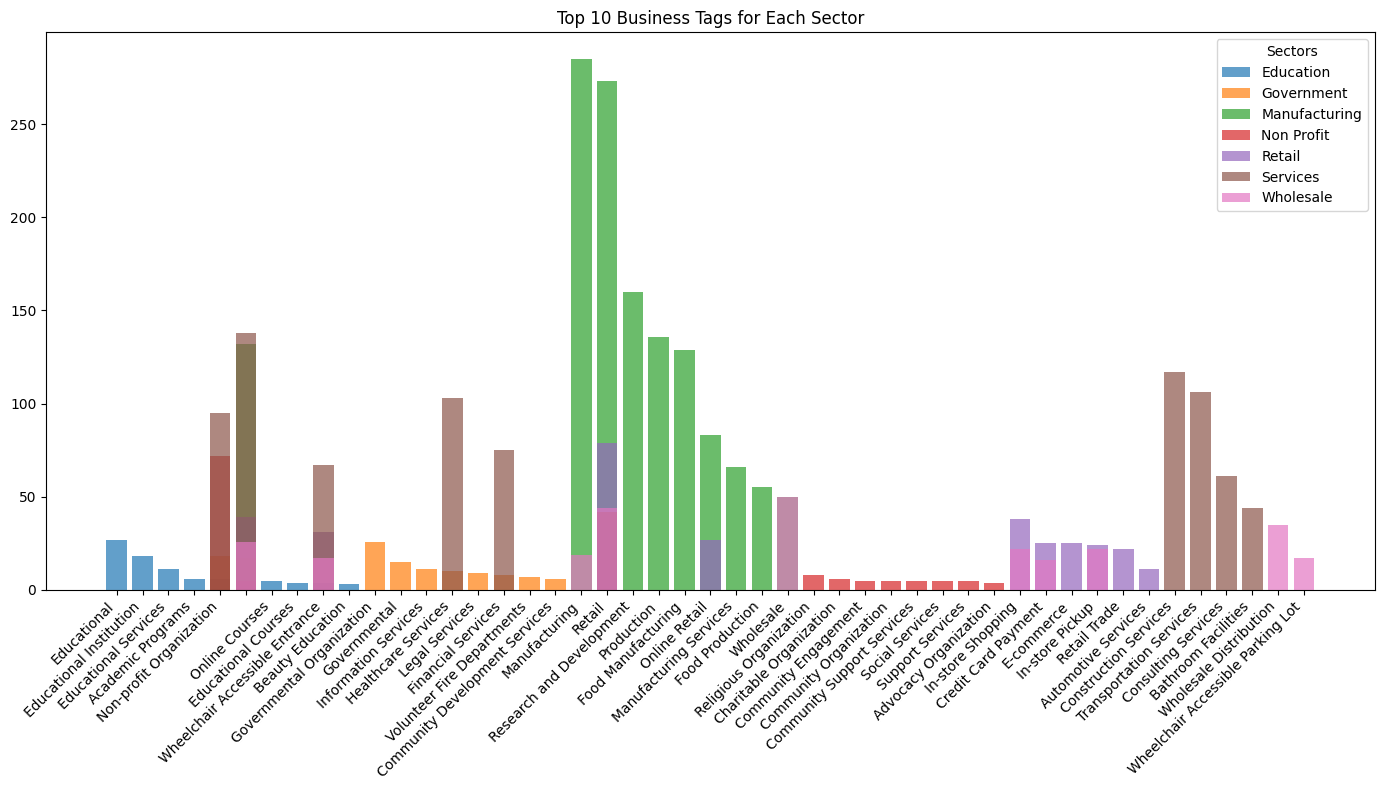

In [173]:
tag_columns = [col for col in companies.columns if "business_tag_" in col]

tag_data = companies.melt(id_vars=["sector"], value_vars=tag_columns, value_name="tag")

tag_data = tag_data.dropna(subset=["tag"])

tag_counts = tag_data.groupby(["sector", "tag"]).size().reset_index(name="count")

top_tags_per_sector = tag_counts.groupby("sector").apply(lambda x: x.nlargest(10, "count")).reset_index(drop=True)

all_tags = []
all_counts = []
all_sectors = []

for sector in top_tags_per_sector["sector"].unique():
    sector_data = top_tags_per_sector[top_tags_per_sector["sector"] == sector]
    all_tags.extend(sector_data["tag"])
    all_counts.extend(sector_data["count"])
    all_sectors.extend([sector] * len(sector_data))

plt.figure(figsize=(14, 8))

for i, sector in enumerate(top_tags_per_sector["sector"].unique()):
    sector_indices = [j for j, sec in enumerate(all_sectors) if sec == sector]
    plt.bar([all_tags[j] for j in sector_indices], [all_counts[j] for j in sector_indices], 
            label=sector, alpha=0.7)

plt.title("Top 10 Business Tags for Each Sector")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sectors")
plt.tight_layout()
plt.show()

### The insurance taxonomy dataframe

In [283]:
insurance = pd.read_csv("data\insurance_taxonomy.csv")
insurance.head(5)

,label
0,Agricultural Equipment Services
1,Soil Nutrient Application Services
2,Pesticide Application Services
3,Ornamental Plant Nurseries
4,Landscaping Services


### Checking for a links between insurance_taxonomy and companies

We assume that the last word in label column represents the sector and tere are overlaping inssurance["label"] with companies["category"]

In [284]:
insurance["sector"] = insurance["label"].str.split(' ').str[-1]
insurance.head(3)

,label,sector
0,Agricultural Equipment Services,Services
1,Soil Nutrient Application Services,Services
2,Pesticide Application Services,Services


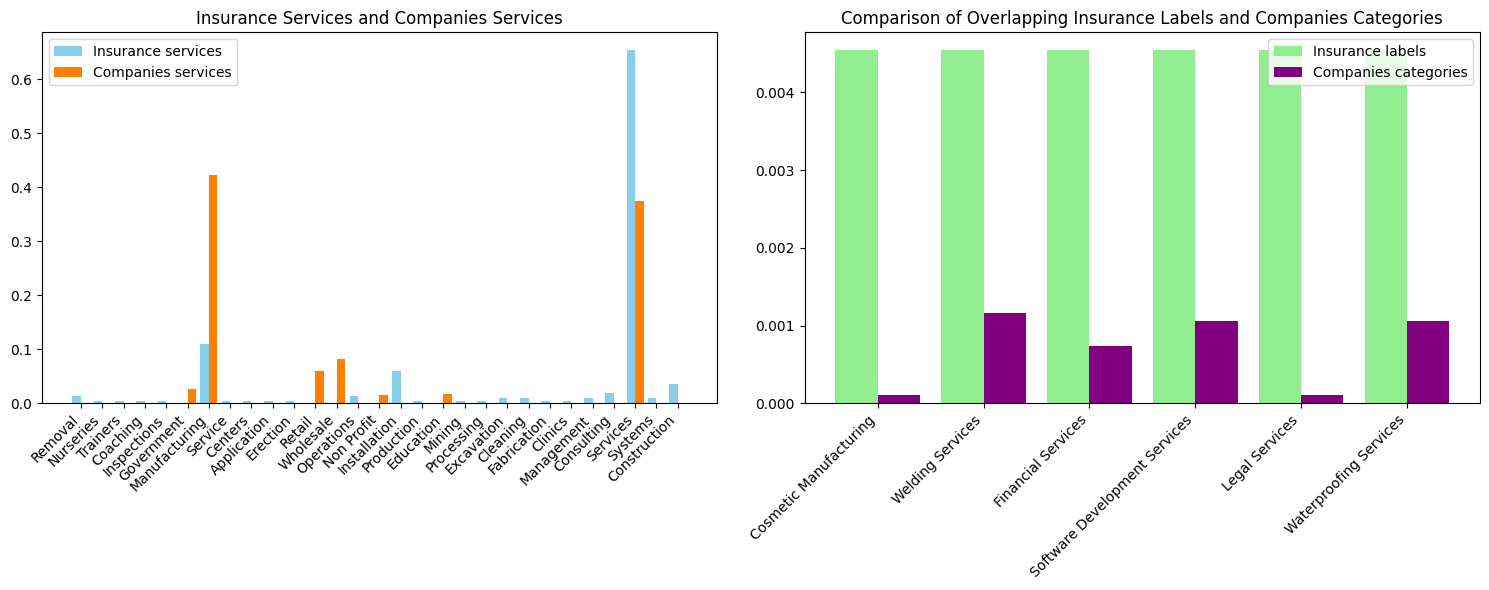

In [93]:
# Compute normalized value counts for sectors
insurance_count = insurance["sector"].value_counts(normalize=True)
sector_count = companies["sector"].value_counts(normalize=True)

# Get all unique sector labels
sector_labels = list(set(insurance_count.index).union(set(sector_count.index)))

# Reindex to include all labels
insurance_count = insurance_count.reindex(sector_labels, fill_value=0)
sector_count = sector_count.reindex(sector_labels, fill_value=0)

# Define x positions
x_pos = range(len(sector_labels))
bar_width = 0.4  


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - Sectors
axes[0].bar([pos - bar_width/2 for pos in x_pos], insurance_count, width=bar_width, color="skyblue", label="Insurance services")
axes[0].bar([pos + bar_width/2 for pos in x_pos], sector_count, width=bar_width, color="#FF7F00", label="Companies services")
axes[0].set_title("Insurance Services and Companies Services")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(sector_labels, rotation=45, ha="right")
axes[0].legend()

# Compute normalized value counts for labels
label_count = insurance["label"].value_counts(normalize=True)
category_count = companies["category"].value_counts(normalize=True)

# Find common categories
common_labels = list(set(label_count.index) & set(category_count.index))

# Filter only common labels
label_count = label_count[common_labels]
category_count = category_count[common_labels]

# Define x positions for second subplot
x_pos = range(len(common_labels))

# Second subplot - Overlapping categories
axes[1].bar([pos - bar_width/2 for pos in x_pos], label_count, width=bar_width, color="lightgreen", label="Insurance labels")
axes[1].bar([pos + bar_width/2 for pos in x_pos], category_count, width=bar_width, color="purple", label="Companies categories")
axes[1].set_title("Comparison of Overlapping Insurance Labels and Companies Categories")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(common_labels, rotation=45, ha="right")
axes[1].legend()

# Show final plot
plt.tight_layout()
plt.show()


### Analysis conclusions:

- The companies have 8 different sectors, 451 categories, and 957 niches.

- The companies have comune tags for different categories

- The most niches are found in "Services" (359), and the fewest are in "Non Profit" (14).

- The initial assumption that the last word in the "labels" column of the insurance_taxonomy would represent the sector of activity was proven false, as there is only overlap with "Manufacturing" and "Services."

- The companies have a total of 57,884 business_tags, of which only 77 are found in the insurance_taxonomy out of a total of 220.

- When comparing niches with labels, only 4 common niches are observed.

## Formatting the Data for FastText

Normalization ensures consistency in text formatting by converting all text to lowercase, removing special characters and extra spaces
I have selected the companies["category"] column as the dataset's label. My goal is to train a FastText model using the company dataset, where the label corresponds to the category, and the rest of the columns (such as the description) will serve as the input features for the model.

In [302]:
def ColumnNormalization(df, column): 
    df.loc[:, column] = df[column].str.replace(r'[^a-zA-Z0-9\s\']', '', regex = True).str.lower()
    df.loc[:, column] = df[column].str.replace(r'\s+', ' ',regex = True)
    df.loc[:, column] = df[column].fillna("")
            
    stemmer = PorterStemmer()
    df.loc[:, column] = df[column].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
        
    stop_words = set(stopwords.words("english"))
    df.loc[:, column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return df


In [303]:
columns = ["description", "category", "niche", "sector"]

for column in columns:
    companies = ColumnNormalization(companies, column)
companies.head(5)

,description,sector,category,niche,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,business_tag_5,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,welchcivil civil engin construct compani speci...,servic,civil engin servic,heavi civil engin construct,Construction Services,Multi-utilities,Utility Network Connections Design and Constru...,Water Connection Installation,Multi-utility Connections,Fiber Optic Installation,...,None,None,None,None,None,None,None,None,None,None
1,kyoto veget specialist uekamo also known iwama...,manufactur,fruit veget market store,frozen fruit juic veget manufactur,Wholesale,Dual-task Movement Products,Cast Iron Products Manufacturer,Manufacturing Technology,Food and Beverage,Rice And Noodles,...,None,None,None,None,None,None,None,None,None,None
2,loidholdhof integr hofgemeinschaft compani off...,manufactur,farm agricultur product,miscellan crop farm,Living Forms,Farm Cafe,Fresh Coffee,Community Engagement,Freshly Baked Bread,Social Interaction Opportunities,...,None,None,None,None,None,None,None,None,None,None
3,patagonia chapa pintura auto bodi shop locat c...,servic,auto bodi shop,automot bodi paint interior repair mainten,Automotive Body Repair Services,Interior Repair Services,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,stanica wodna pttk swornegaci cultur establish...,servic,boat tour cruis,scenic sightse transport water,Cultural Activities,Accommodation Services,Kayak Rentals,Small Gastronomy Products,Tourism Services,Recreational Activities,...,None,None,None,None,None,None,None,None,None,None


In [304]:
def LabelColumns(df, column):

    df[column] = df[column].str.replace(r"\s+", "_", regex=True)
    df.loc[pd.notna(df[column]) & (df[column] != ""), column] = "__label__" + df[column]
    return df

In [305]:
companies_labels = companies.drop(columns=["description", "category", "niche", "sector"])
companies_labels.head(3)

,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,business_tag_5,business_tag_6,business_tag_7,business_tag_8,business_tag_9,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,Construction Services,Multi-utilities,Utility Network Connections Design and Constru...,Water Connection Installation,Multi-utility Connections,Fiber Optic Installation,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Wholesale,Dual-task Movement Products,Cast Iron Products Manufacturer,Manufacturing Technology,Food and Beverage,Rice And Noodles,High-quality Gloss of Cast Iron,Rice Wholesaler,Miscellaneous Crop Farming,Health and Wellness Products,...,None,None,None,None,None,None,None,None,None,None
2,Living Forms,Farm Cafe,Fresh Coffee,Community Engagement,Freshly Baked Bread,Social Interaction Opportunities,Fresh Vegetables,Homemade Honey,Delicious Cakes,Community-oriented Living,...,None,None,None,None,None,None,None,None,None,None


In [306]:
for col in companies_labels.columns:
    if companies[col].notna().any():
        companies = LabelColumns(companies, col)

In [307]:
companies.head(3)

,description,sector,category,niche,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,business_tag_5,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,welchcivil civil engin construct compani speci...,servic,civil engin servic,heavi civil engin construct,__label__Construction_Services,__label__Multi-utilities,__label__Utility_Network_Connections_Design_an...,__label__Water_Connection_Installation,__label__Multi-utility_Connections,__label__Fiber_Optic_Installation,...,None,None,None,None,None,None,None,None,None,None
1,kyoto veget specialist uekamo also known iwama...,manufactur,fruit veget market store,frozen fruit juic veget manufactur,__label__Wholesale,__label__Dual-task_Movement_Products,__label__Cast_Iron_Products_Manufacturer,__label__Manufacturing_Technology,__label__Food_and_Beverage,__label__Rice_And_Noodles,...,None,None,None,None,None,None,None,None,None,None
2,loidholdhof integr hofgemeinschaft compani off...,manufactur,farm agricultur product,miscellan crop farm,__label__Living_Forms,__label__Farm_Cafe,__label__Fresh_Coffee,__label__Community_Engagement,__label__Freshly_Baked_Bread,__label__Social_Interaction_Opportunities,...,None,None,None,None,None,None,None,None,None,None


In [308]:
companies_labels = companies.drop(columns=["description", "category", "niche", "sector"])
companies_labels.head(3)

,business_tag_0,business_tag_1,business_tag_2,business_tag_3,business_tag_4,business_tag_5,business_tag_6,business_tag_7,business_tag_8,business_tag_9,...,business_tag_53,business_tag_54,business_tag_55,business_tag_56,business_tag_57,business_tag_58,business_tag_59,business_tag_60,business_tag_61,business_tag_62
0,__label__Construction_Services,__label__Multi-utilities,__label__Utility_Network_Connections_Design_an...,__label__Water_Connection_Installation,__label__Multi-utility_Connections,__label__Fiber_Optic_Installation,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,__label__Wholesale,__label__Dual-task_Movement_Products,__label__Cast_Iron_Products_Manufacturer,__label__Manufacturing_Technology,__label__Food_and_Beverage,__label__Rice_And_Noodles,__label__High-quality_Gloss_of_Cast_Iron,__label__Rice_Wholesaler,__label__Miscellaneous_Crop_Farming,__label__Health_and_Wellness_Products,...,None,None,None,None,None,None,None,None,None,None
2,__label__Living_Forms,__label__Farm_Cafe,__label__Fresh_Coffee,__label__Community_Engagement,__label__Freshly_Baked_Bread,__label__Social_Interaction_Opportunities,__label__Fresh_Vegetables,__label__Homemade_Honey,__label__Delicious_Cakes,__label__Community-oriented_Living,...,None,None,None,None,None,None,None,None,None,None


In [309]:
companies["labels"] = ""

In [310]:
for col in companies_labels.columns:
    companies["labels"] += " " + companies[col].fillna("")

In [311]:
companies["labels"] = companies["labels"].str.strip()

In [312]:
companies["labels"].iloc[0]

'__label__Construction_Services __label__Multi-utilities __label__Utility_Network_Connections_Design_and_Construction __label__Water_Connection_Installation __label__Multi-utility_Connections __label__Fiber_Optic_Installation'

In [313]:
companies["final_text"] = companies["labels"] + " " + companies["description"] + " " + companies["category"] + " " + companies["niche"] + " " + companies["sector"]

In [259]:
companies["final_text"].iloc[0]

'__label__Construction_Services __label__Multi-utilities __label__Utility_Network_Connections_Design_and_Construction __label__Water_Connection_Installation __label__Multi-utility_Connections __label__Fiber_Optic_Installation welchcivil civil engin construct compani special design build util network connect across uk offer multiutil solut combin electr ga water fibr optic instal singl contract design engin team capabl design electr water ga network exist network connect point meter locat develop well project manag reinforc diver provid custom connect solut take account ani exist asset maxim usag everi trench meet project deadlin welchcivil ha consid experti instal ga electr connect varieti market categori includ residenti commerci industri project well civil engin servic heavi civil engin construct servic'

In [314]:
companies_lables = companies["final_text"]

In [274]:
companies_lables.to_csv("data\companies_labels.csv", index=False)

In [287]:
insurance["label_norm"] = insurance["label"]
insurance = ColumnNormalization(insurance, "label_norm")
insurance = insurance.drop(columns="sector")
insurance

,label,label_norm
0,Agricultural Equipment Services,agricultur equip servic
1,Soil Nutrient Application Services,soil nutrient applic servic
2,Pesticide Application Services,pesticid applic servic
3,Ornamental Plant Nurseries,ornament plant nurseri
4,Landscaping Services,landscap servic
...,...,...
215,Sports Management Services,sport manag servic
216,Fitness Coaching,fit coach
217,Health Promotion Services,health promot servic
218,Physical Therapy Services,physic therapi servic


In [289]:
insurance.to_csv("data/taxonomy.csv", index=False)

## Splitting the dataset

Split the dataset into 80% train set and 20% test set

In [315]:
sector_column = companies['sector']
data = companies_lables

train_data, test_data, train_sector_column, test_sector_column = train_test_split(
    data, sector_column, test_size=0.2, stratify=sector_column, random_state=42)

In [263]:
print(f"Training data: {train_data.shape[0]} rows")
print(f"Testing data: {test_data.shape[0]} rows")

Training data: 7564 rows
Testing data: 1891 rows


In [264]:
test_data.to_csv("data/test_data.txt", index=False, header=False, sep='\t')

Split the train set into 90% train set and 10% validation set

In [265]:
new_train_data, val_data, new_train_sector_column, val_sector_column = train_test_split(
    train_data, train_sector_column, test_size=0.1, stratify=train_sector_column, random_state=42)

In [266]:
print(f"Training data: {new_train_data.shape[0]} rows")
print(f"Validation data: {val_data.shape[0]} rows")

Training data: 6807 rows
Validation data: 757 rows


In [267]:
new_train_data.to_csv("data/train_data.txt", index=False, header=False, sep='\t')
val_data.to_csv("data/val_data.txt", index=False, header=False, sep='\t')

In [318]:
sector_column = companies['sector']
data = companies_copy

train_data, test_data, train_sector_column, test_sector_column = train_test_split(
    data, sector_column, test_size=0.2, stratify=sector_column, random_state=42)